In [1]:
%load_ext autoreload
%autoreload 2

# Verification of MINA routines against D717A weld from Moysan (2003)
This notebook compares the outputs of:
* `mina_weld` package
* David Fan's MATLAB implementation of MINA from NDE Lab repository
* the image from Moysan (2003).

### Missing data from Moysan (2003):
* the number of passes per layer; they may only be inferred from Fig 2., but this is prone to error.
* the height of the top parabola is also not given.


In [2]:
"""
A test validating mina-weld against Moysan et al. (2003), case D717A
Created by: Michal K. Kalkowski
20/02/2018

License: MIT
"""
import numpy as np
import matplotlib.pyplot as plt
import mina.mina_model as mina

# Create weld model
weld_parameters = dict([('remelt_h', 0.47),
                        ('remelt_v', 0.26),
                        ('theta_b', np.deg2rad(18)),
                        ('theta_c', np.deg2rad(12)),
                        ('order', 'left_to_right'),
                        ('number_of_layers', 11),
                        ('number_of_passes', np.array([1]*1 + 4*[2] + 2*[3] +
                                                      [4]*4)),
                        ('electrode_diameter', np.array([1.6, 2.5, 3.2, 4] +
                                                        [5]*4 + [4]*3)),
                        ('a', 38),
                        ('b', 4),
                        ('c', 36)])
weld = mina.MINA_weld(weld_parameters)
weld.define_grid_size(2., use_centroids=False)
weld.h_top = 0.2
weld.solve()
# weld.fill_missing()


------MINA model setup------
Horizontal remelting rate: 0.47
Vertical remelting rate: 0.26
theta_b and theta_c: 0.3141592653589793 and 0.20943951023931956
Order of passes: left_to_right
Number of layers: 11
Number of passes: [1 2 2 2 2 3 3 4 4 4 4]
Electrode diameter: [1.6 2.5 3.2 4.  5.  5.  5.  5.  4.  4.  4. ]
Weld thickness: 38
Chamfer base: 4
Chamfer top: 36
----------------------------


## Passes layout

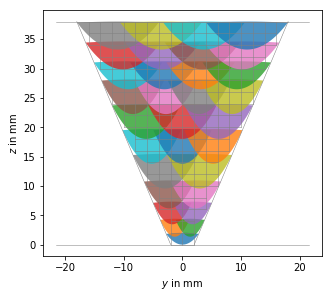

In [3]:
weld.plot_passes(grid=True)
# plt.plot(weld.point_o[:, 0], weld.point_o[:, 1], 'o')

## Final orientations: element centroid-based

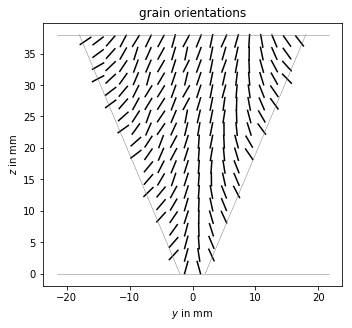

In [4]:
weld.define_grid_size(2., use_centroids=True)
weld.solve()
# weld.fill_missing()
weld.plot_grain_orientations(grid=False)

## Nodes based - 'missing' nodes filled with mean of orientations in surrounding elements.

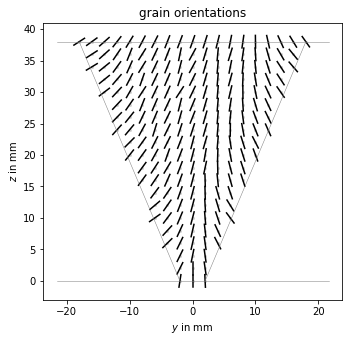

In [5]:
weld.define_grid_size(2., use_centroids=False)
weld.h_top = 0.2
weld.solve()
weld.fill_missing()
weld.plot_grain_orientations(grid=True)

## David Fan's code

![](../references/D_Fan_MATLAB_prediction_Moysan_2003.png)

## Original - Moysan (2003)
![](../references/Moysan_2003.png)

## General observations:
* results are qualitatively similar, but differences occur. 
* overall my code is quite close to Moysan (2003), while David's appears to be in worse agreement.
* I am in favour of the element-centroid based calculation; the result does not change much but if feels somewhat more appropriate and coherent. Both DF and Moysan (2003) use a nodes based approach and take the outcome of seeding as MINA grid; `mina weld` takes the midpoints between seeds as MINA grid.
* I validated the key parameters of MINA model (layers, pass widths, pass centre coordinates etc.) with DF - they all agree.

## Potential reasons for discrepancies with David Fan's code:
* DF uses parallelopipeds to model a pass, not two parabolas as in Moysan (2003); the consequence is that some MINA grid points are assigned to different passes as compared to `mina_weld` and the original paper, with different thermal gradients, etc.
* inside the epitaxial growth loop - DF treats the lowest element as if the underlying grain orientation was 0; then, he uses the epitaxial growth loop to bring it closer to the temperature gradient.
* in `mina_weld`, the lowest element adopts and keeps the thermal gradient calculated geometrically; the epitaxial growth loop is applied from layer two onwards (MINA grid layer, not layer of passes).
* `mina_weld` requires some 'height' of the top parabola; otherwise, some MINA grid points will not be covered; DF does not use parabolas to determine parent pass, hence he does not need the top height. This problem was highlighted in Gueudre et al. (2009) and it seems that `mina_weld` follows the original, as similar issues are encountered. `mina_weld` addresses this problem by calculating the mean orientation of all neighbouring MINA elements and assigning this mean to the unassigned element.

## Other issues:
* weld root is supposed to be 4 mm (as Moysan, 2003 indicates). On the other hand, for a 2 mm grid, the figure from  Moysan (2003) indicates the weld root of 6 mm (four orientation lines are present). Something is clearly wrong here.